## Example script for training the L2HMC sampler

## Imports / setup for training

In [1]:
%load_ext autoreload
%autoreload 2

import logging
import datetime
import os
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
try:
    import horovod
    import horovod.tensorflow as hvd
    try:
        RANK = hvd.rank()
    except ValueError:
        hvd.init()
        
    RANK = hvd.rank()
    HAS_HOROVOD = True
    logging.info(f'Using horovod version: {horovod.__version__}')
    logging.info(f'Using horovod from: {horovod.__file__}')
    GPUS = tf.config.experimental.list_physical_devices('GPU')
    for gpu in GPUS:
        tf.config.experimental.set_memory_growth(gpu, True)
    if GPUS:
        gpu = GPUS[hvd.local_rank()]
        tf.config.experimental.set_visible_devices(gpu, 'GPU')
except ImportError:
    HAS_HOROVOD = False

import tensorflow as tf
from rich.console import Console
from rich.theme import Theme
from rich import print

if os.path.abspath('..') not in sys.path:
    sys.path.append(os.path.abspath('..'))
    
sns.set_palette('bright')

plt.style.use('default')
sns.set_context('talk')
sns.set_style('whitegrid')
sns.set_palette('bright')

plt.rc('text', usetex=True)

console = Console(theme=Theme({"repr.number": "#ff79ff"}),
                  force_jupyter=True, 
                  width=180, log_time=True, log_time_format='[%X]')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load configs from `BIN_DIR/train_configs.json`:

In [2]:
import json
from config import BIN_DIR

train_configs_file = os.path.join(BIN_DIR, 'train_configs.json')
with open(train_configs_file, 'rt') as f:
    configs = json.load(f)
    
configs.update({
    'train_steps': 1000,
    'run_steps': 1000,
    'save_steps': 500,
    'logging_steps': 5,
    'print_steps': 5,
    'beta_init': 2.,
    'beta_final': 2.,
})

configs['dynamics_config'].update({
    'num_steps': 10,
    'x_shape': [512, 16, 16, 2],
})

console.log(configs)

tf.__version__: 2.4.0-dev20201016


Get timestamp and create `log_dir` where everything will live

In [3]:
import utils.file_io as io
from utils.attr_dict import AttrDict

io.console = console

# Keep history of `log_dir` for later reference
log_file = os.path.join(os.getcwd(), 'log_dirs.txt')

configs = AttrDict(configs)

timestamps = AttrDict({
    'month': io.get_timestamp('%Y_%m'),
    'time': io.get_timestamp('%Y-%m-%d-%H%M%S'),
    'hour': io.get_timestamp('%Y-%m-%d-%H'),
    'minute': io.get_timestamp('%Y-%m-%d-%H%M'),
    'second': io.get_timestamp('%Y-%m-%d-%H%M%S'),
})

log_dir = io.make_log_dir(configs, 'GaugeModel', log_file,
                          timestamps=timestamps)
configs.log_dir = log_dir
io.write(f'{configs.log_dir}', log_file, 'a')

## Run training:

To demonstrate that everything is working correctly, we only train for `configs.train_steps = 100` training steps.

In [4]:
from utils.training_utils import train 

# Only make plots for 8 chains to speed up plotting
num_chains_to_plot = 8

# Draw initial x uniformly from [-pi, pi]:
x_shape = configs.dynamics_config.get('x_shape', None)
x = tf.random.uniform(x_shape, minval=-np.pi, maxval=np.pi)
x = tf.reshape(x, (x.shape[0], -1))

x, dynamics, train_data, configs = train(configs,
                                         x=x, make_plots=False,
                                         num_chains=num_chains_to_plot,
                                         should_track=False)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2311: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:1399: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


ReduceLROnPlateau (step <tf.Variable 'iter:0' shape=() dtype=int64, numpy=551>): Reducing learning rate from: 0.0010000000474974513 to 0.0009900000470224768.
current: -16.949464797973633, best: -19.233007431030273


ReduceLROnPlateau (step <tf.Variable 'iter:0' shape=() dtype=int64, numpy=601>): Reducing learning rate from: 0.0009900000877678394 to 0.000980100086890161.
current: -20.178165435791016, best: -23.712448120117188


ReduceLROnPlateau (step <tf.Variable 'iter:0' shape=() dtype=int64, numpy=621>): Reducing learning rate from: 0.000980100128799677 to 0.0009702991275116801.
current: -18.649173736572266, best: -23.712448120117188


ReduceLROnPlateau (step <tf.Variable 'iter:0' shape=() dtype=int64, numpy=641>): Reducing learning rate from: 0.0009702991228550673 to 0.0009605961316265165.
current: -17.01909065246582, best: -23.712448120117188


ReduceLROnPlateau (step <tf.Variable 'iter:0' shape=() dtype=int64, numpy=681>): Reducing learning rate from: 0.0009605961386114359 to 0.0009509901772253215.
current: -21.108699798583984, best: -27.29445457458496


ReduceLROnPlateau (step <tf.Variable 'iter:0' shape=() dtype=int64, numpy=701>): Reducing learning rate from: 0.0009509901865385473 to 0.0009414802846731617.
current: -19.19078826904297, best: -27.29445457458496


ReduceLROnPlateau (step <tf.Variable 'iter:0' shape=() dtype=int64, numpy=721>): Reducing learning rate from: 0.0009414802771061659 to 0.0009320654743351042.
current: -20.461708068847656, best: -27.29445457458496


ReduceLROnPlateau (step <tf.Variable 'iter:0' shape=() dtype=int64, numpy=741>): Reducing learning rate from: 0.0009320654789917171 to 0.0009227448242017999.
current: -22.530807495117188, best: -27.29445457458496


ReduceLROnPlateau (step <tf.Variable 'iter:0' shape=() dtype=int64, numpy=761>): Reducing learning rate from: 0.0009227448026649654 to 0.0009135173546383158.
current: -17.453964233398438, best: -27.29445457458496


ReduceLROnPlateau (step <tf.Variable 'iter:0' shape=() dtype=int64, numpy=781>): Reducing learning rate from: 0.0009135173750109971 to 0.0009043822012608871.
current: -24.60987091064453, best: -27.29445457458496


ReduceLROnPlateau (step <tf.Variable 'iter:0' shape=() dtype=int64, numpy=831>): Reducing learning rate from: 0.0009043822064995766 to 0.0008953383844345808.
current: -23.87152862548828, best: -29.942649841308594


ReduceLROnPlateau (step <tf.Variable 'iter:0' shape=() dtype=int64, numpy=851>): Reducing learning rate from: 0.0008953383658081293 to 0.000886384982150048.
current: -19.42559242248535, best: -29.942649841308594


ReduceLROnPlateau (step <tf.Variable 'iter:0' shape=() dtype=int64, numpy=871>): Reducing learning rate from: 0.0008863849798217416 to 0.0008775211300235242.
current: -20.424293518066406, best: -29.942649841308594


ReduceLROnPlateau (step <tf.Variable 'iter:0' shape=() dtype=int64, numpy=891>): Reducing learning rate from: 0.0008775211172178388 to 0.0008687459060456604.
current: -22.203617095947266, best: -29.942649841308594


ReduceLROnPlateau (step <tf.Variable 'iter:0' shape=() dtype=int64, numpy=911>): Reducing learning rate from: 0.0008687459048815072 to 0.0008600584458326921.
current: -19.950733184814453, best: -29.942649841308594


ReduceLROnPlateau (step <tf.Variable 'iter:0' shape=() dtype=int64, numpy=931>): Reducing learning rate from: 0.0008600584696978331 to 0.0008514578850008547.
current: -23.715063095092773, best: -29.942649841308594


ReduceLROnPlateau (step <tf.Variable 'iter:0' shape=() dtype=int64, numpy=951>): Reducing learning rate from: 0.0008514578803442419 to 0.0008429433015407995.
current: -25.340862274169922, best: -29.942649841308594


ReduceLROnPlateau (step <tf.Variable 'iter:0' shape=() dtype=int64, numpy=971>): Reducing learning rate from: 0.0008429433219134808 to 0.0008345138886943459.
current: -24.20890235900879, best: -29.942649841308594


ReduceLROnPlateau (step <tf.Variable 'iter:0' shape=() dtype=int64, numpy=991>): Reducing learning rate from: 0.0008345138630829751 to 0.0008261687244521454.
current: -20.24713706970215, best: -29.942649841308594


### Make plots from training data
---

Explicitly, we look at the how the following quantities evolve during training:

\begin{itemize}
    \item The loss $\mathcal{L}_{\theta}$
    \item The various stepsizes, $\varepsilon_{x},\, \varepsilon_{v}$
    \item The error in the average plaquette $\langle\delta\phi_{P}\rangle$
    \item The error in the average $4\times4$ Wilson loop $\langle\mathcal{W}_{4\times4}\rangle$
    \item The `sumlogdet`, overall Jacobian factor $\sum\left|\mathcal{J}\right|$
    \item The acceptance probability as well as the discretized accept/reject  mask $A(\xi^{\prime}|\xi)$, $m_{A(\xi^{\prime}|\xi)}$
    \item The integer-valued topological charge $\mathcal{Q}_{\mathbb{Z}}$
    \item The tunneling rate(s) 
    \begin{equation}
        \delta_{\mathcal{Q}_{\mathcal{X}}}(\xi^{\prime}, \xi) \equiv |\mathcal{Q}_{\mathcal{X}}^{\prime} -  \mathcal{Q}_{\mathcal{X}}|
    \end{equation}
     for $\mathcal{X} \in \left\{\mathbb{R}, \mathbb{Z}\right\}$.
\end{itemize}

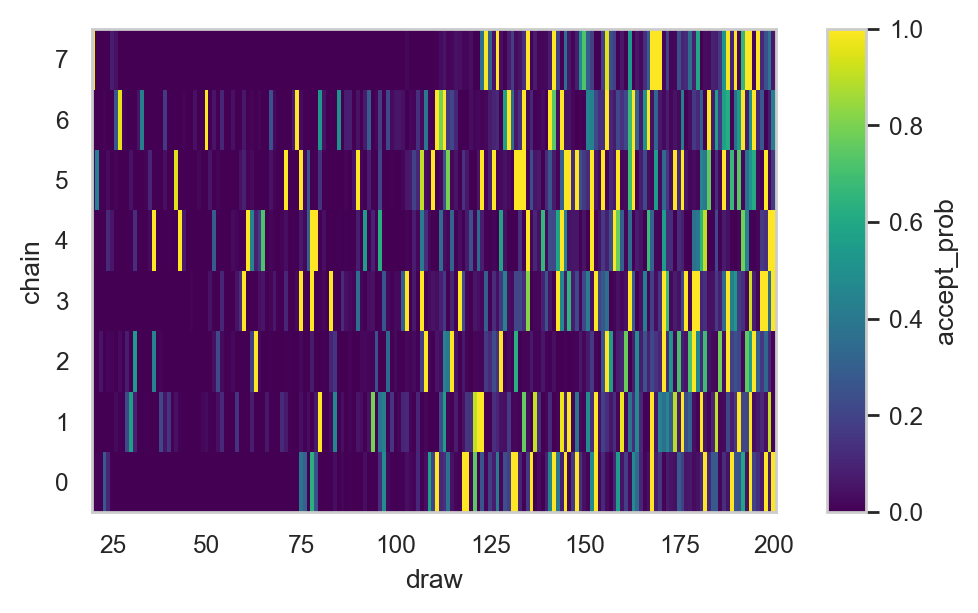

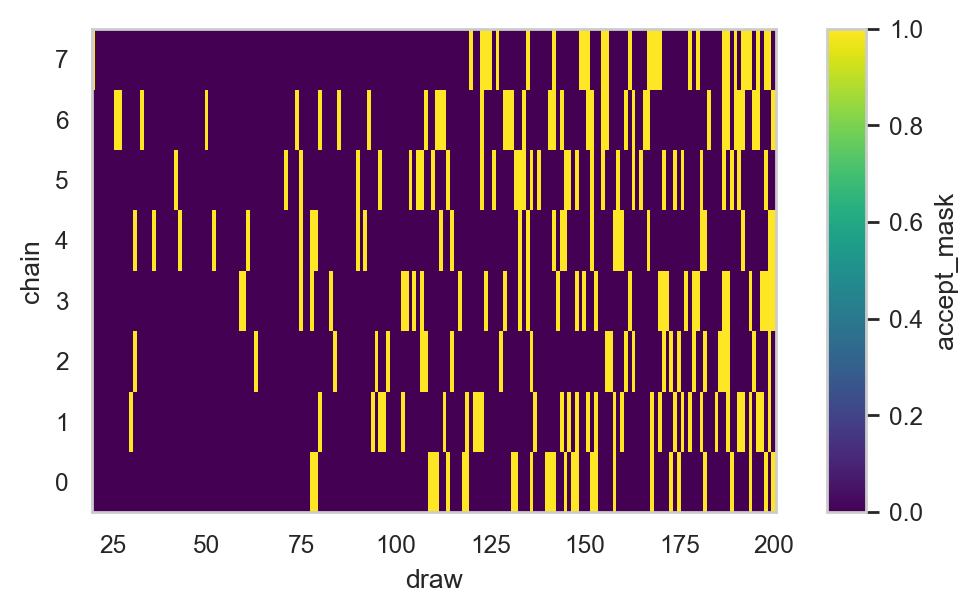

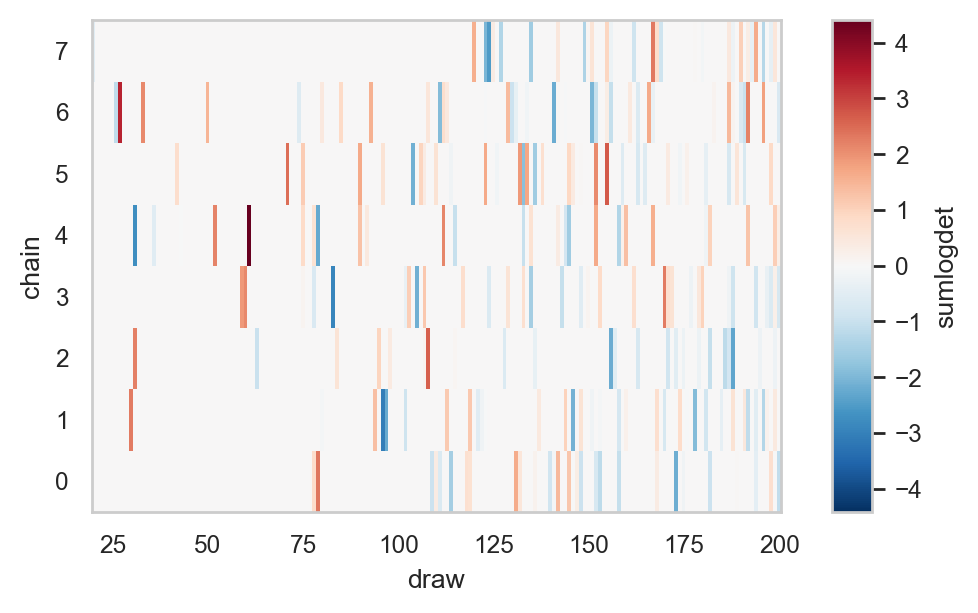

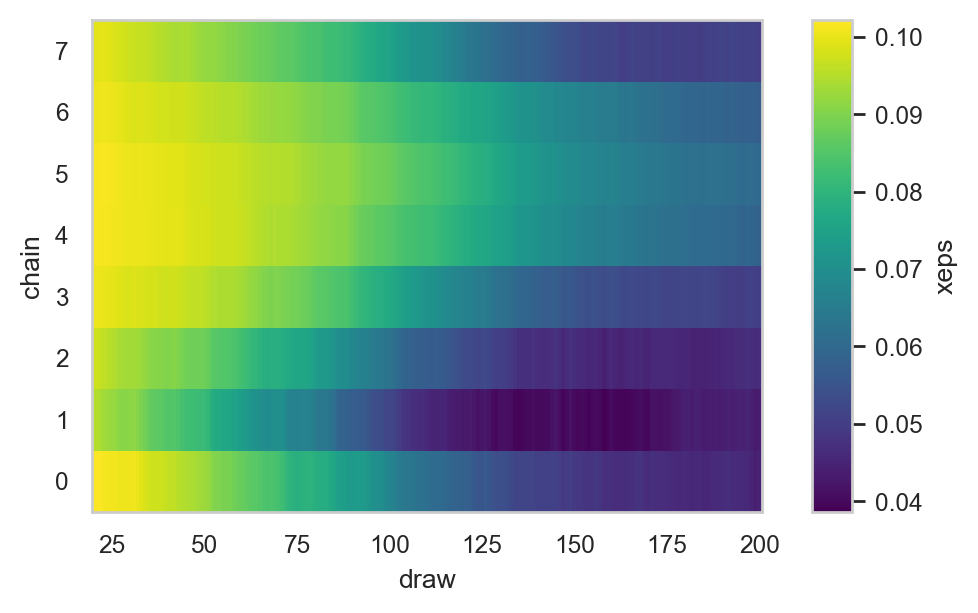

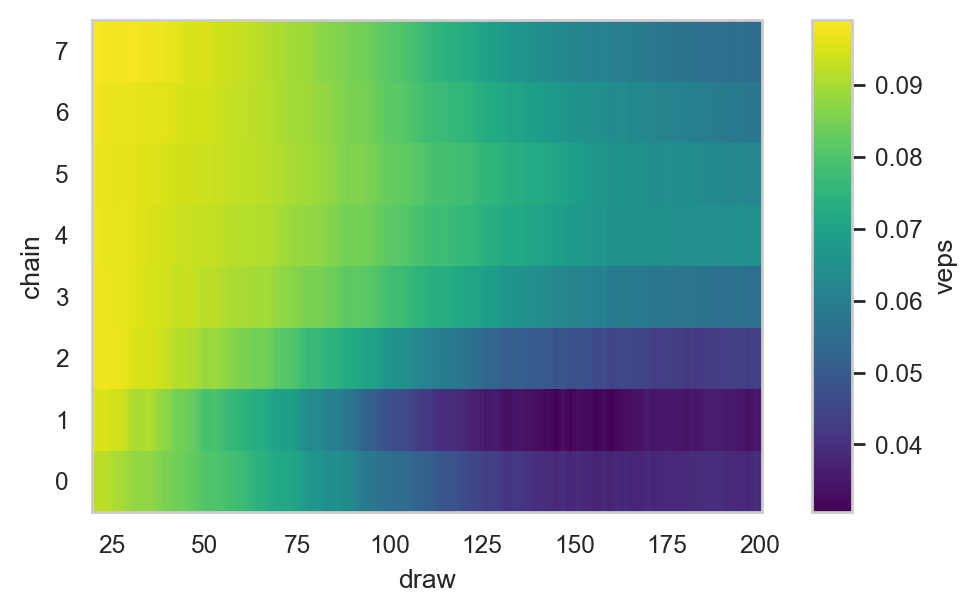

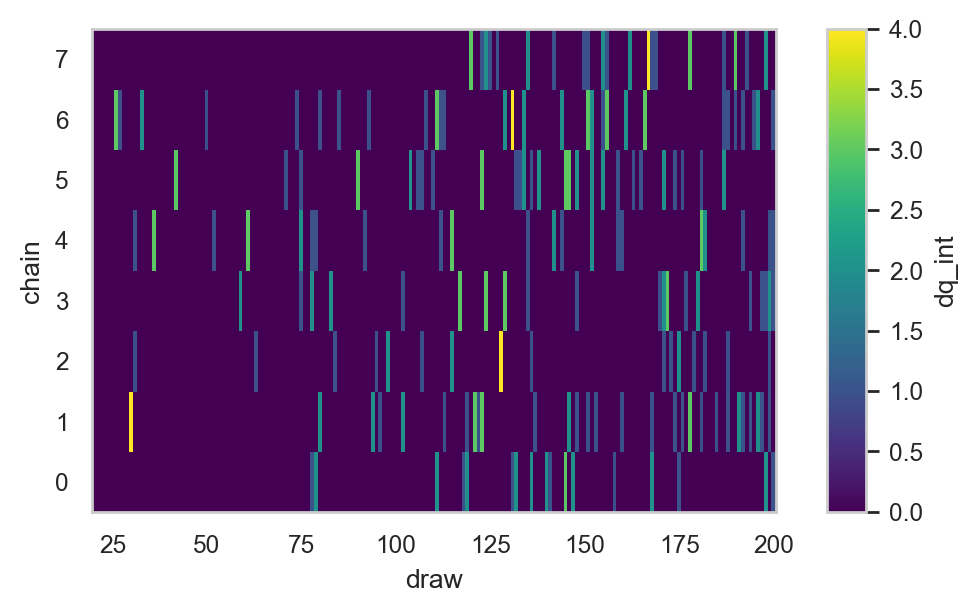

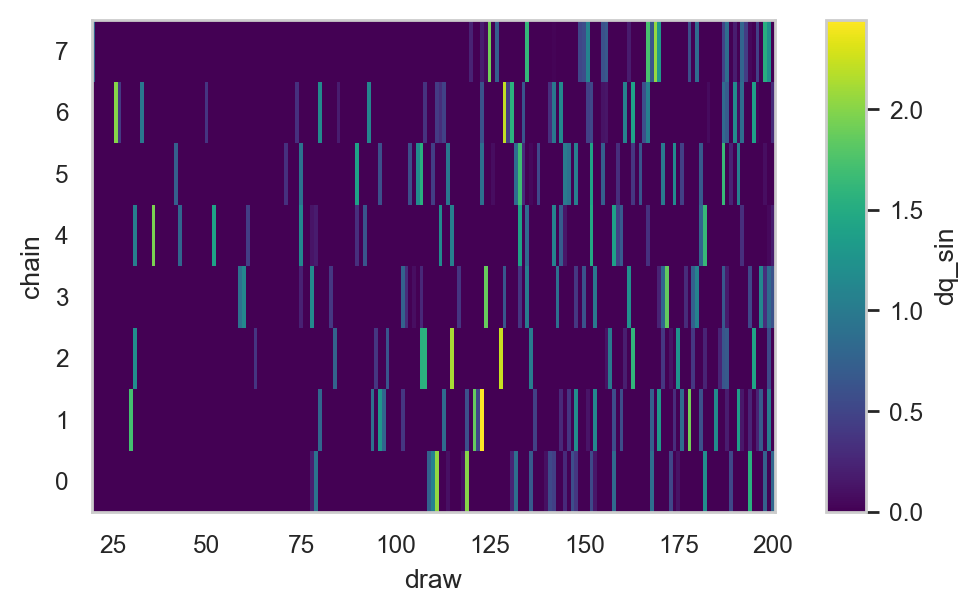

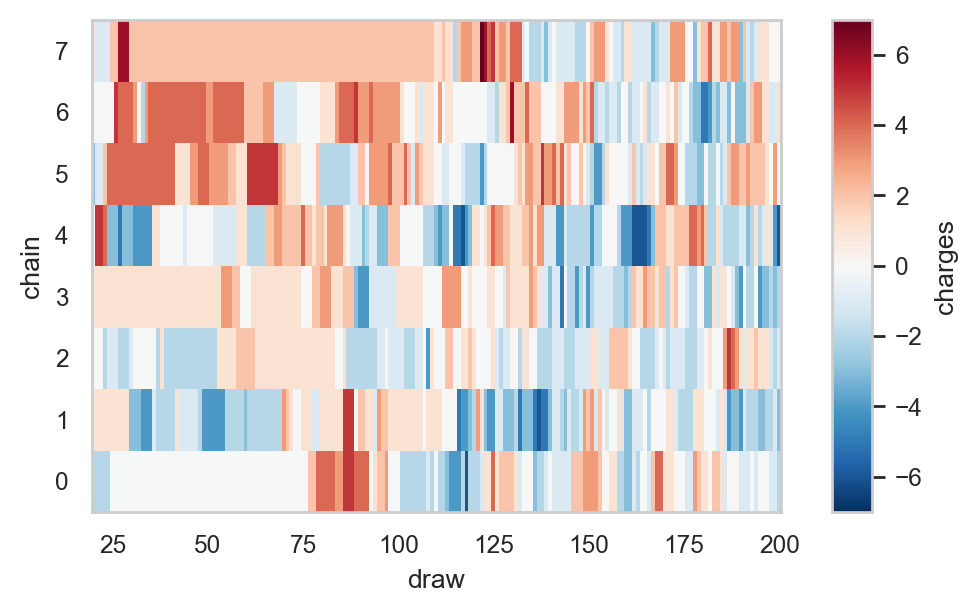

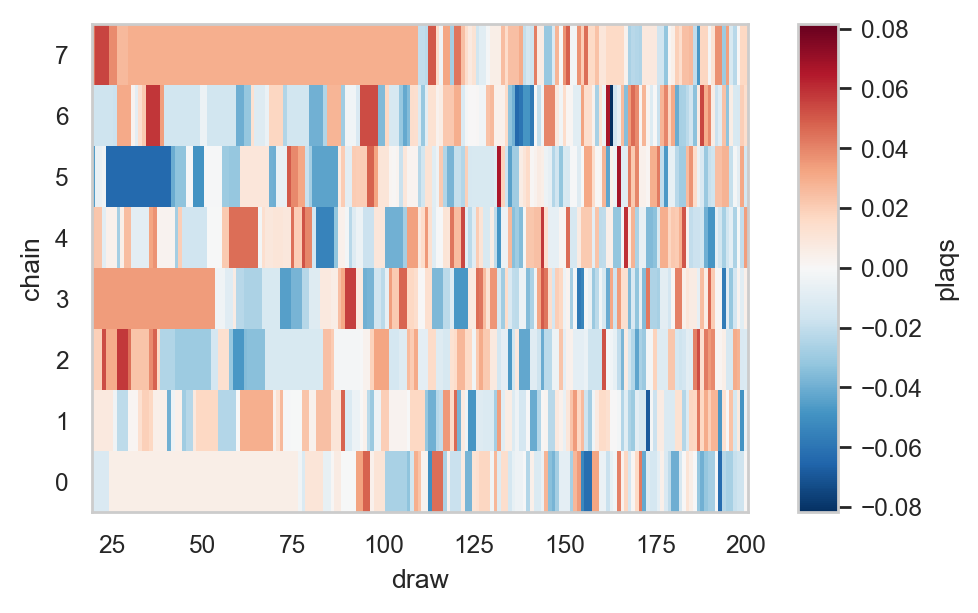

In [5]:
from utils.plotting_utils import set_size

to_plot = [
    'xeps', 'veps',
    'plaqs', 'p4x4'
    'loss', 'sumlogdet',
    'accept_prob', 'accept_mask',
    'charges', 'dq_int', 'dq_sin',
]


train_dataset = train_data.get_dataset(therm_frac=0.1)
for key, val in train_dataset.data_vars.items():
    if key not in to_plot:
        continue
        
    val = val[:num_chains_to_plot]
    fig, ax = plt.subplots(constrained_layout=True, figsize=set_size())
    _ = val.plot(ax=ax)

/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  sel

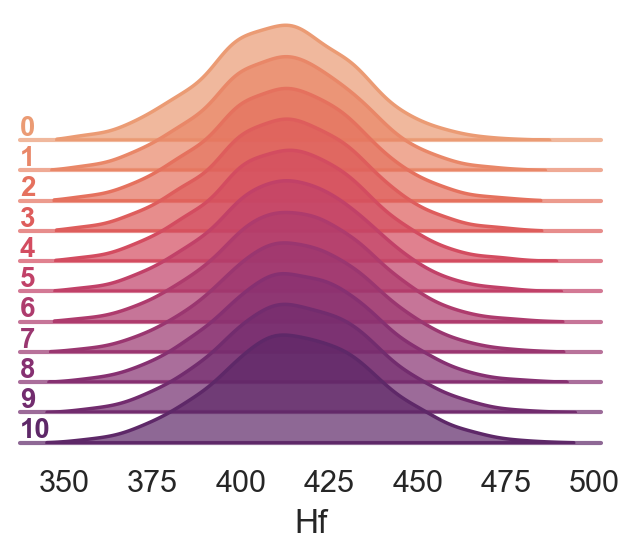

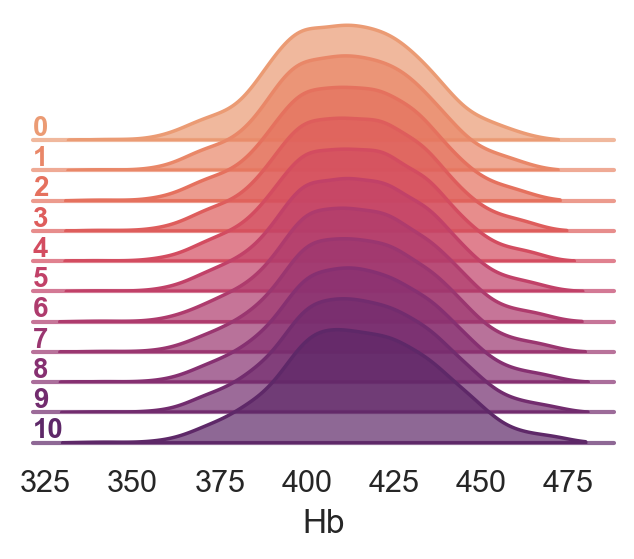

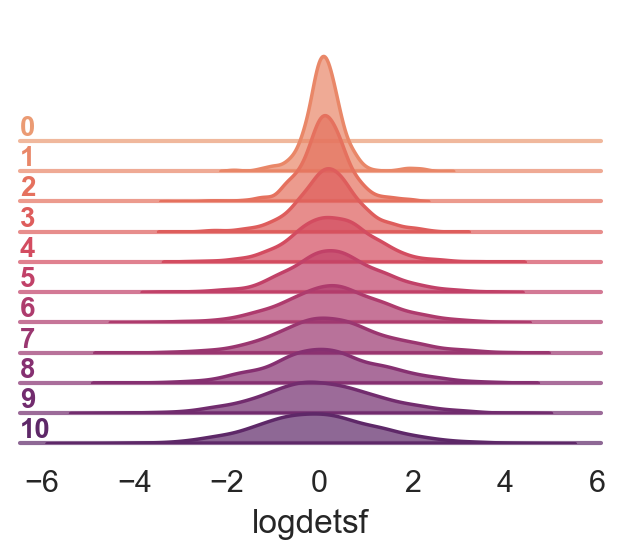

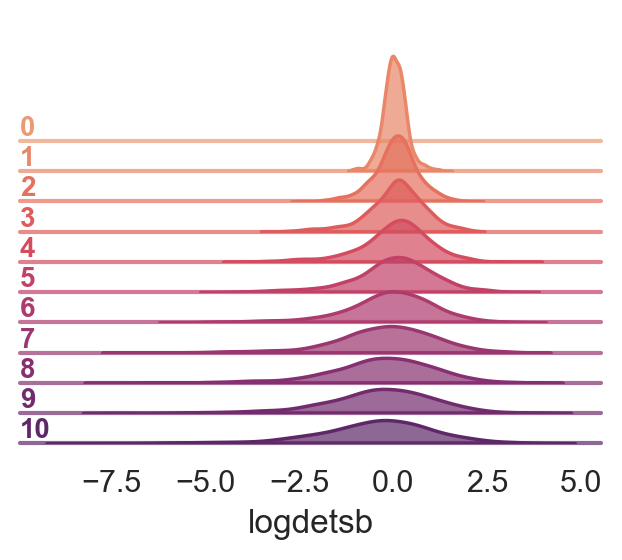

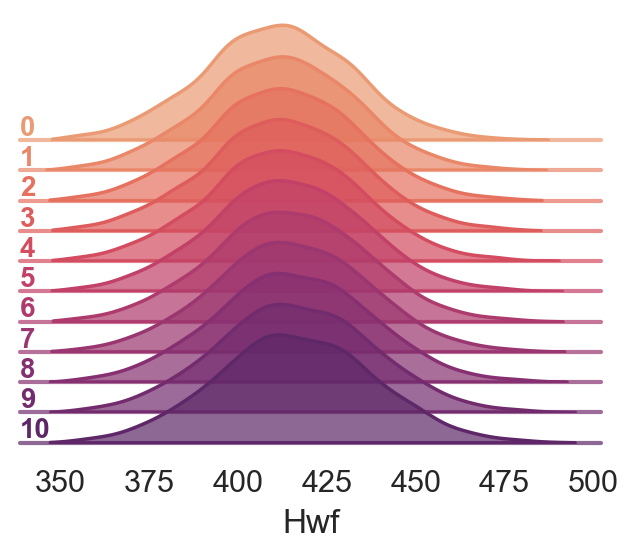

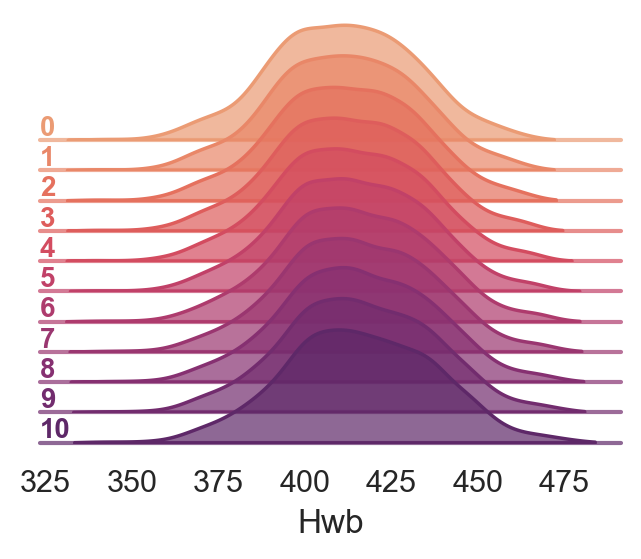

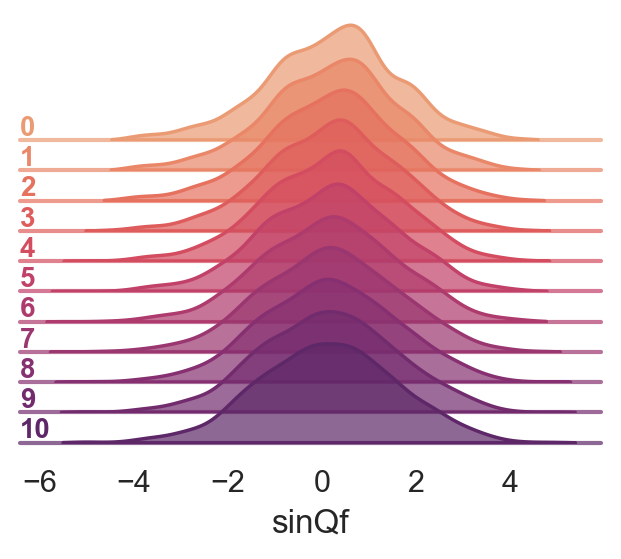

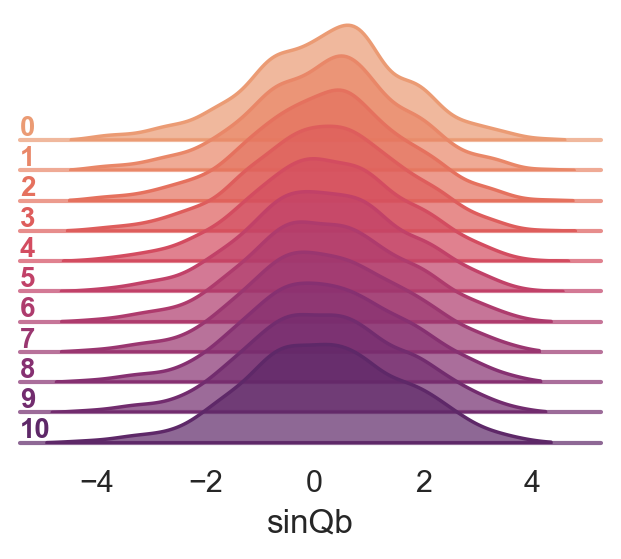

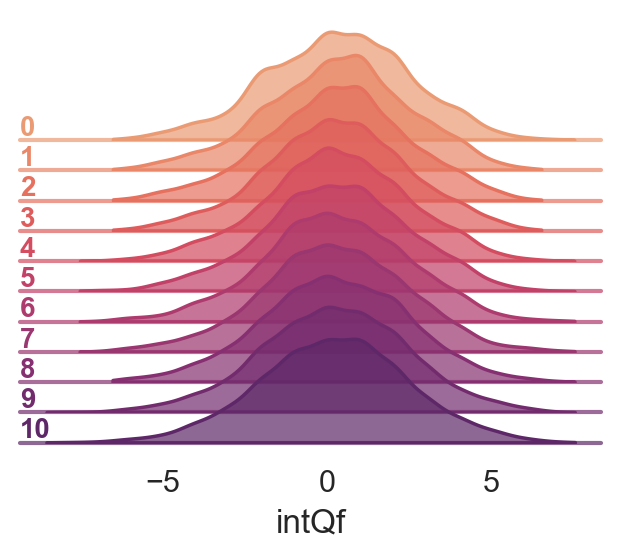

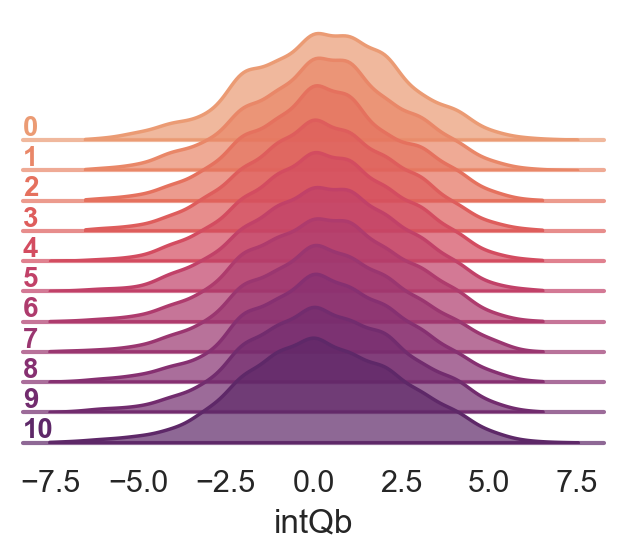

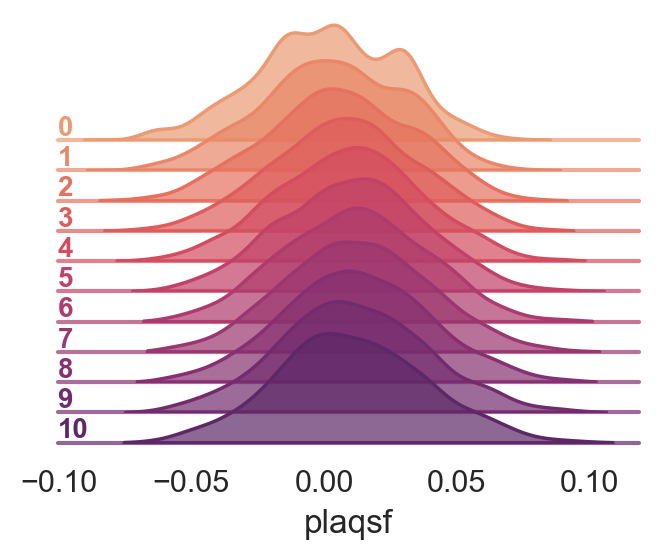

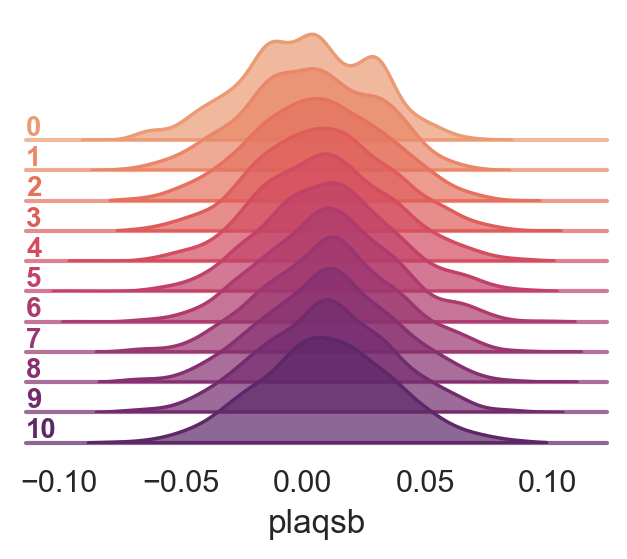

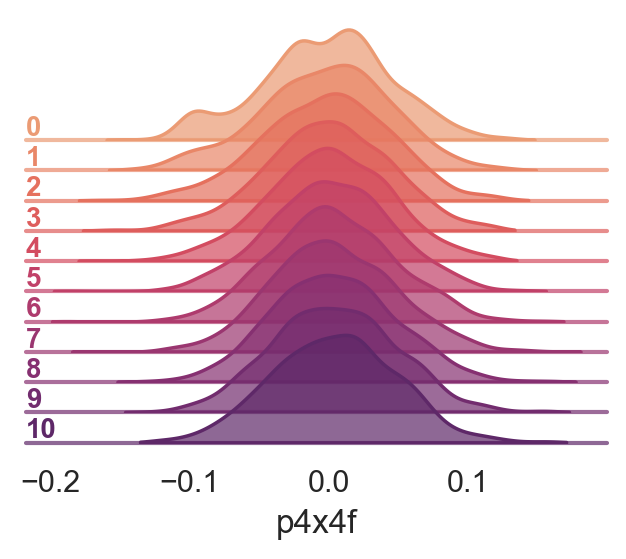

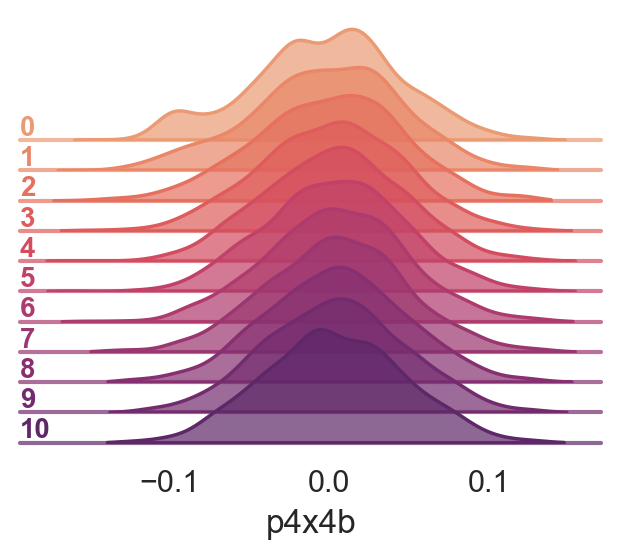

In [6]:
from utils.plotting_utils import make_ridgeplots

_ = make_ridgeplots(train_dataset, num_chains=8)

In [7]:
from utils.inference_utils import run as run_inference

if configs.get('run_steps', None) > 0:
    log_dir = configs.log_dir
    beta = configs.get('beta_final', None)
    inference_results = run_inference(dynamics=dynamics,
                                      x=x,
                                      args=configs, 
                                      beta=beta,
                                      make_plots=True,
                                      therm_frac=0.2,
                                      num_chains=num_chains_to_plot,
                                      console=console,
                                      save_x=False)

/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  sel

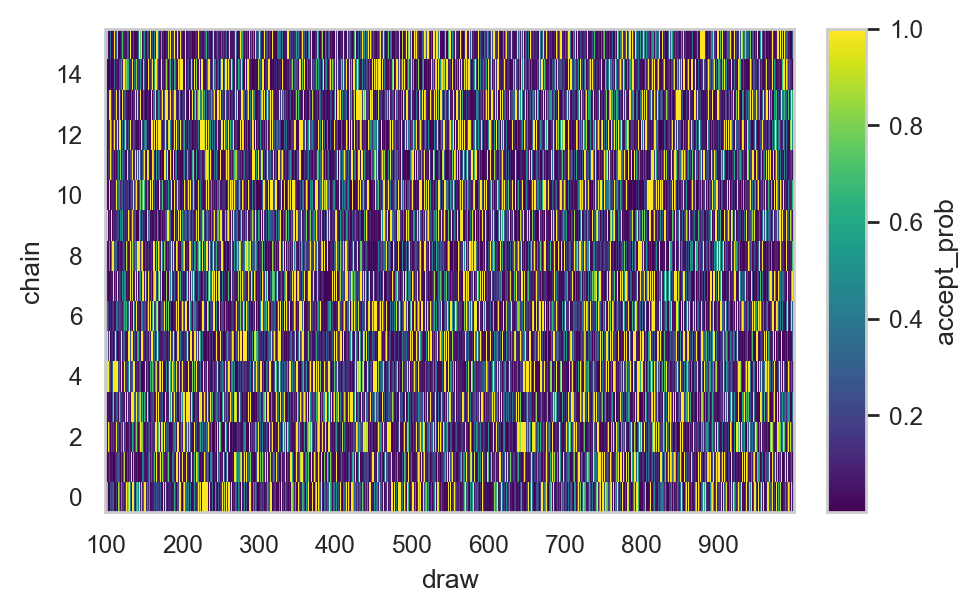

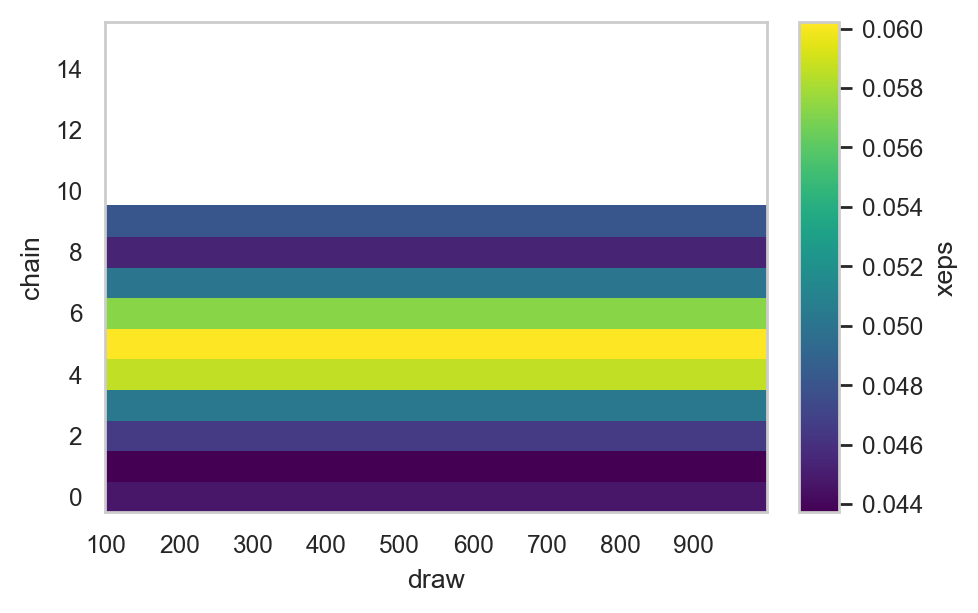

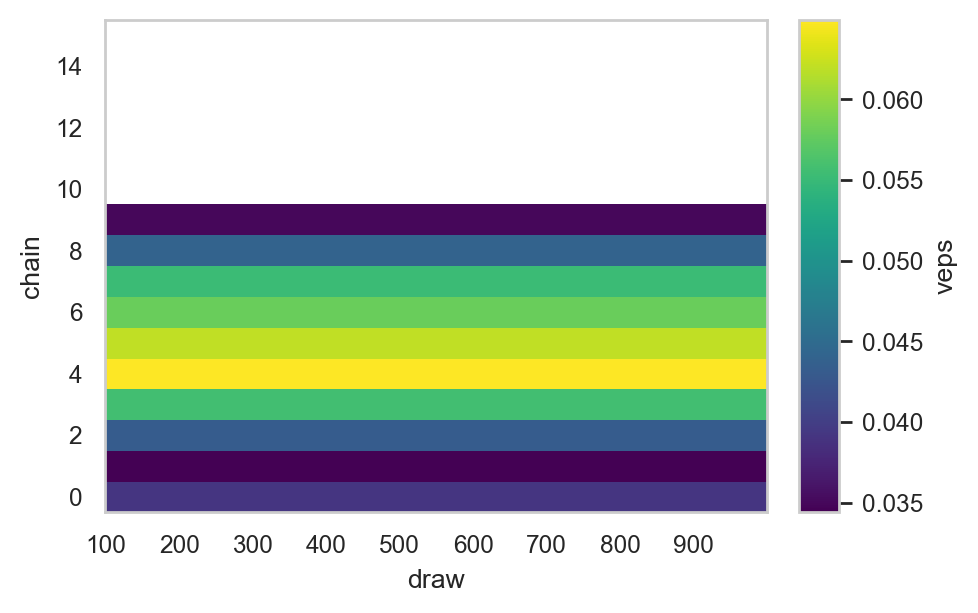

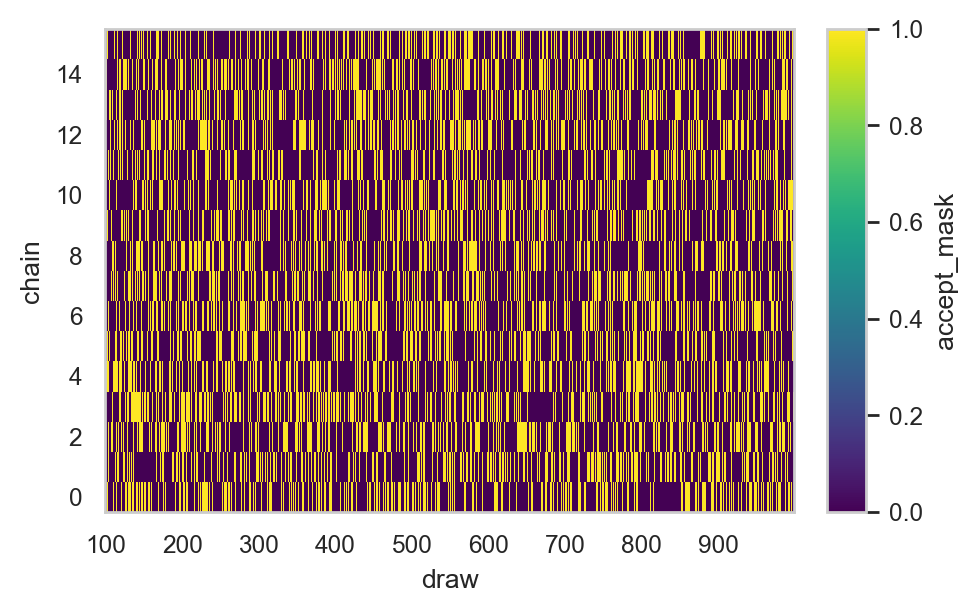

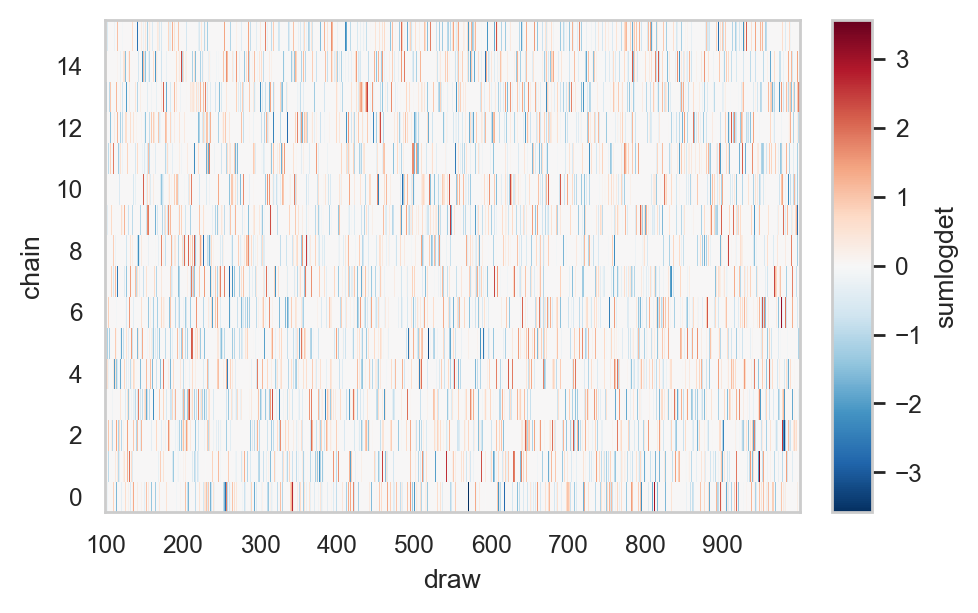

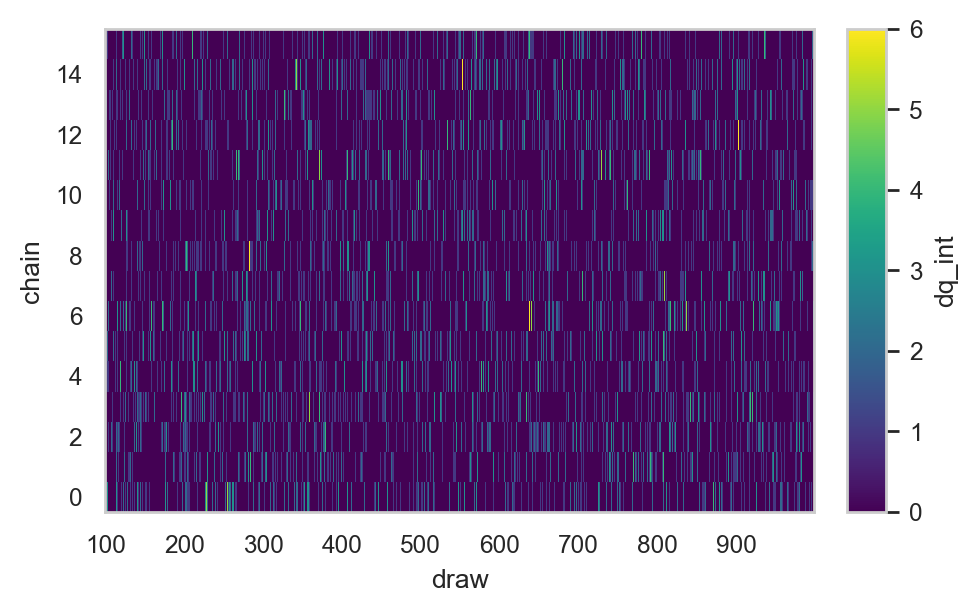

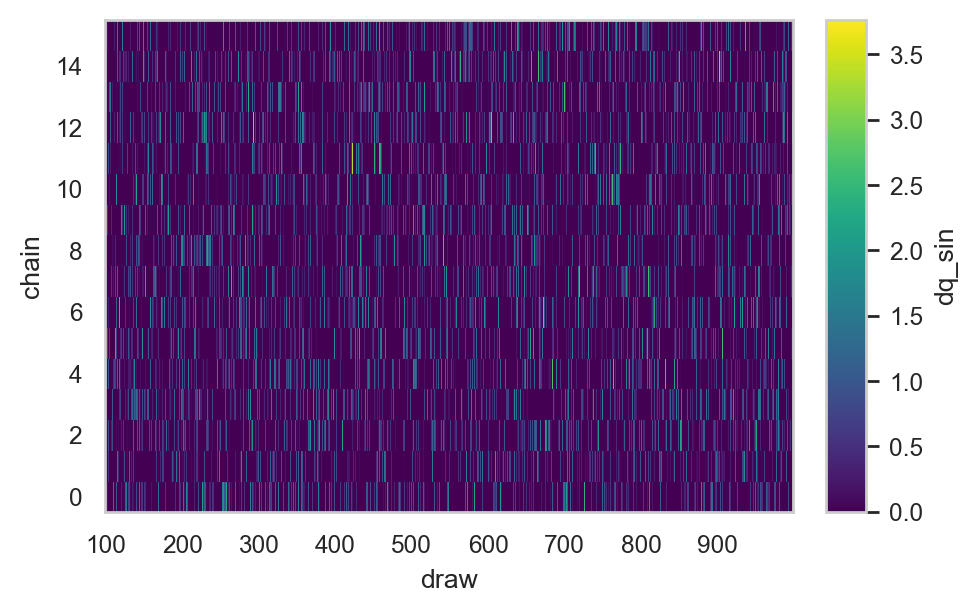

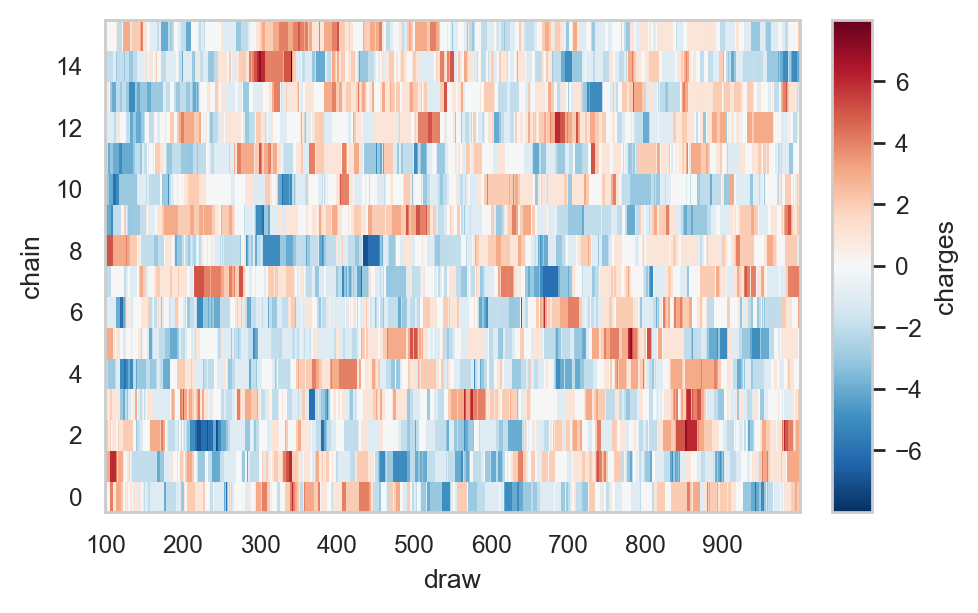

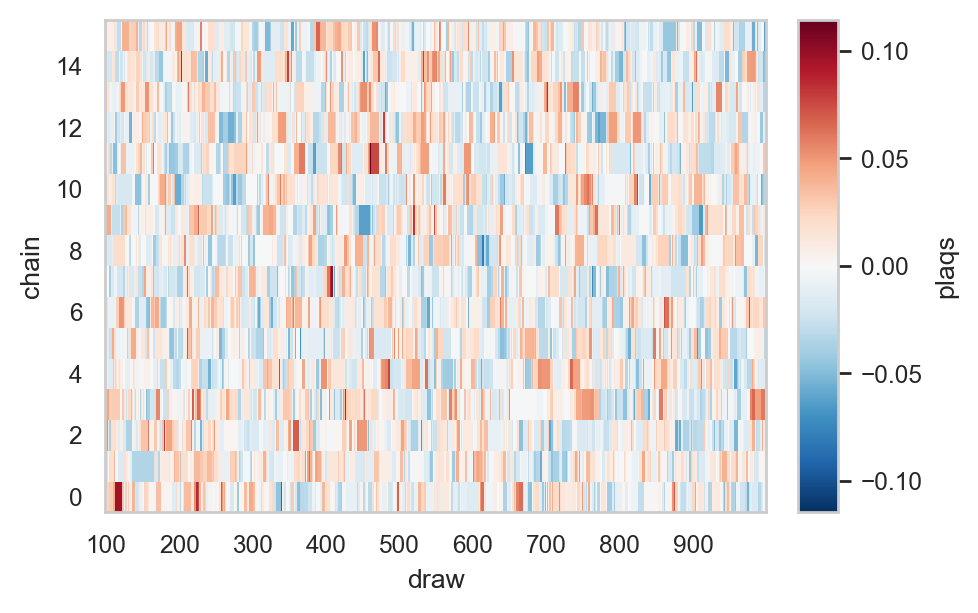

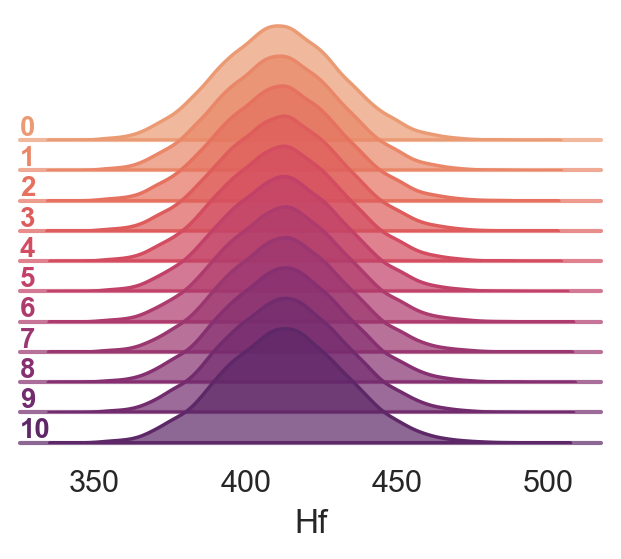

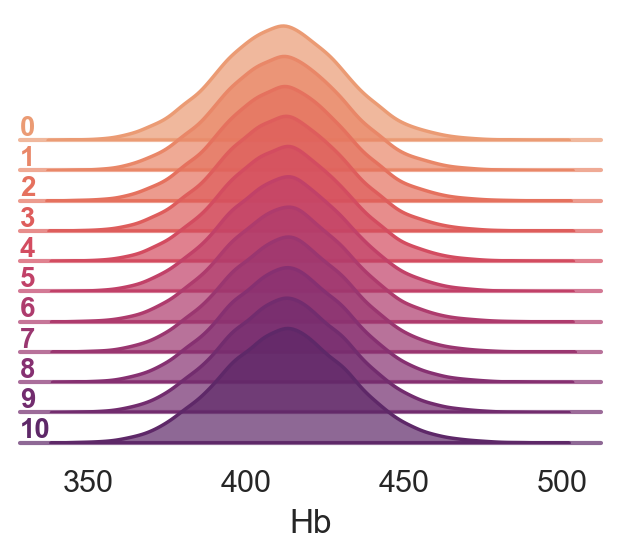

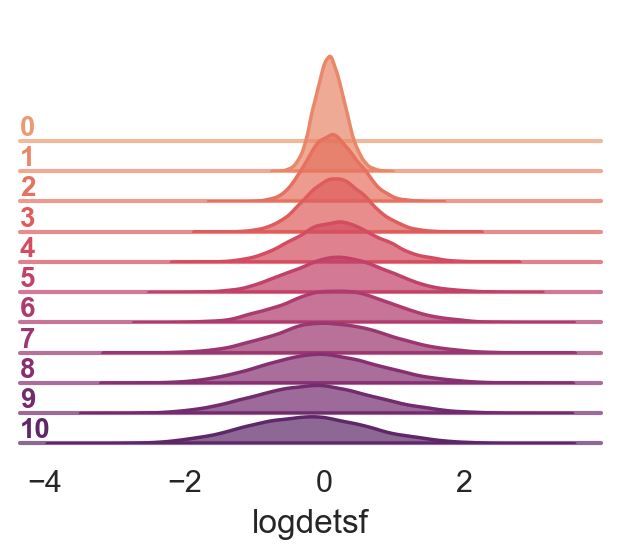

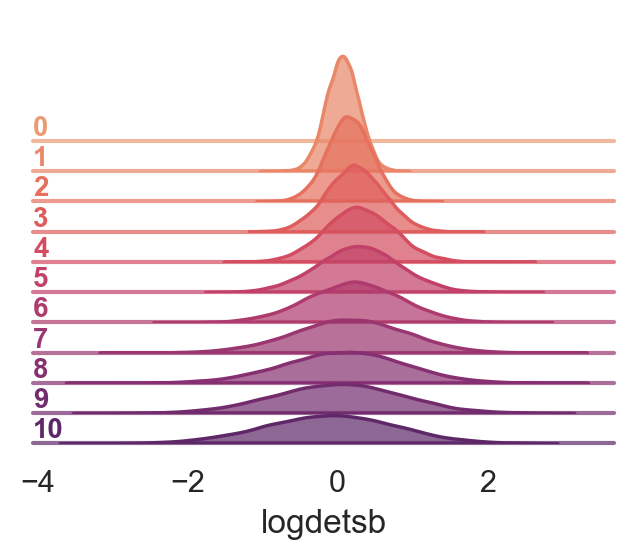

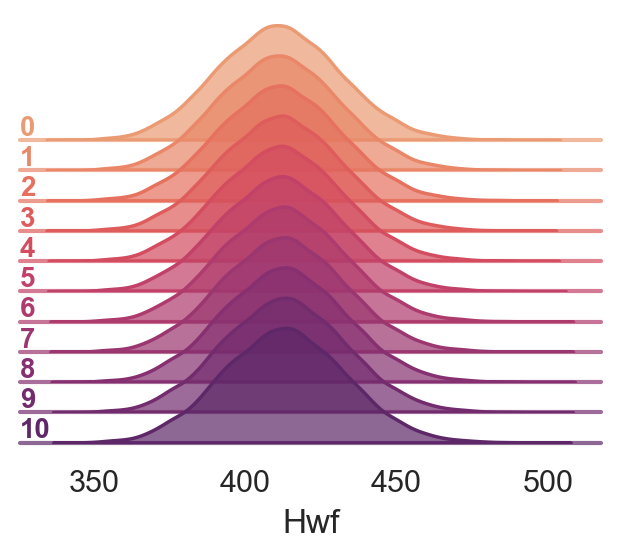

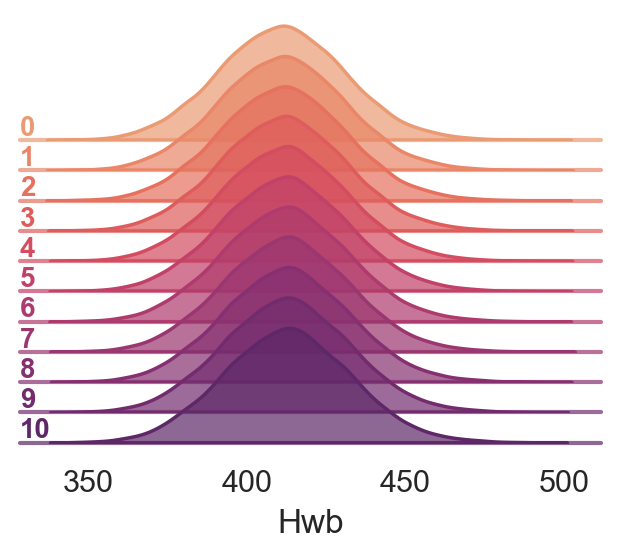

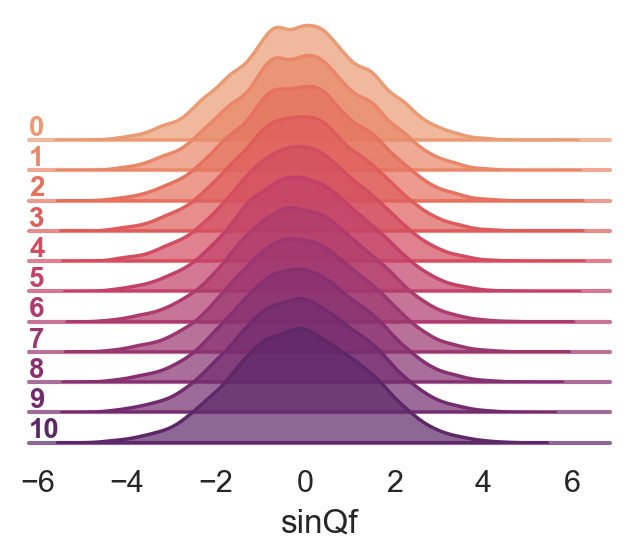

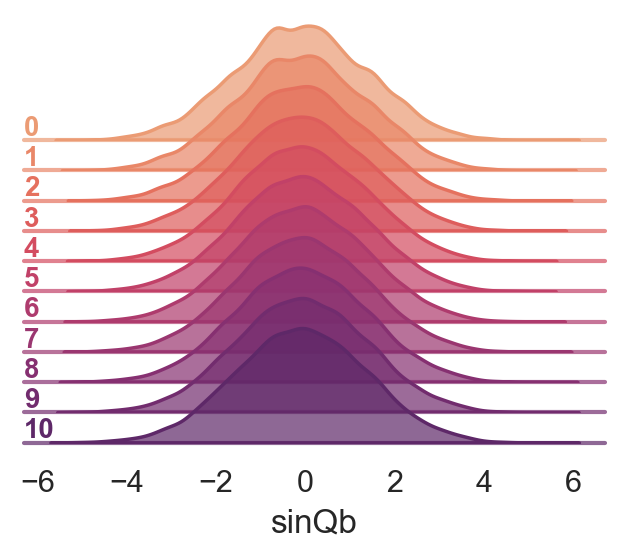

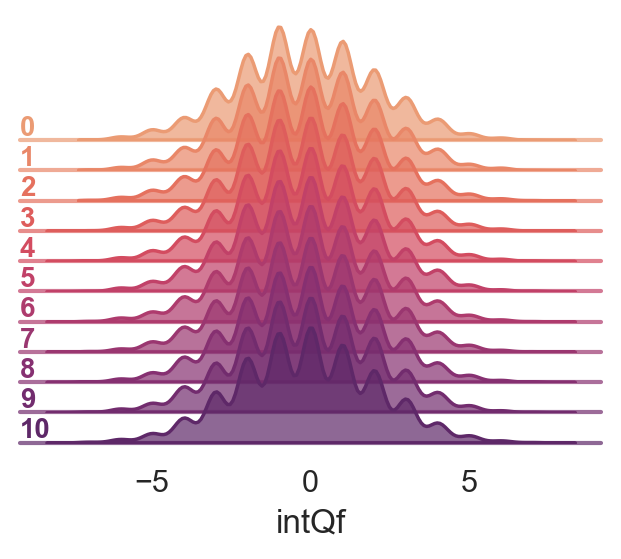

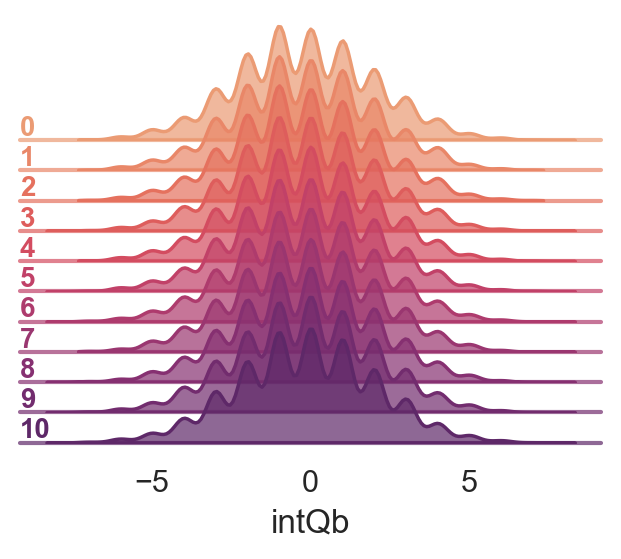

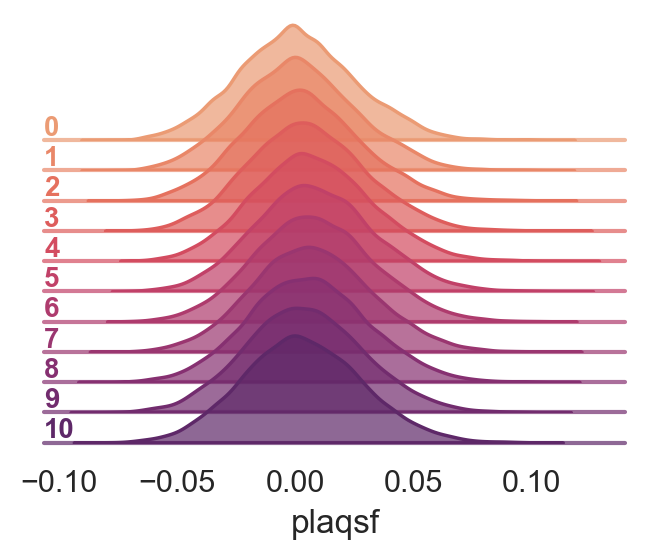

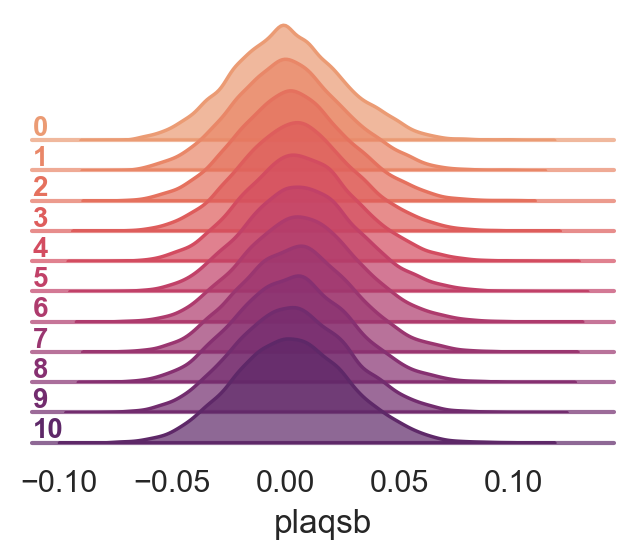

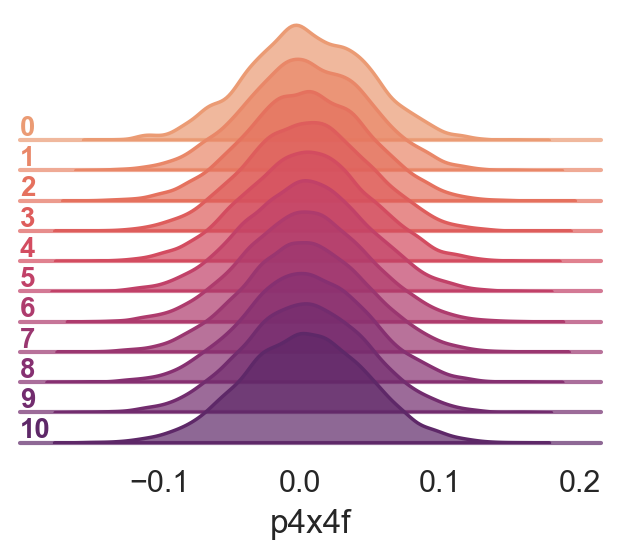

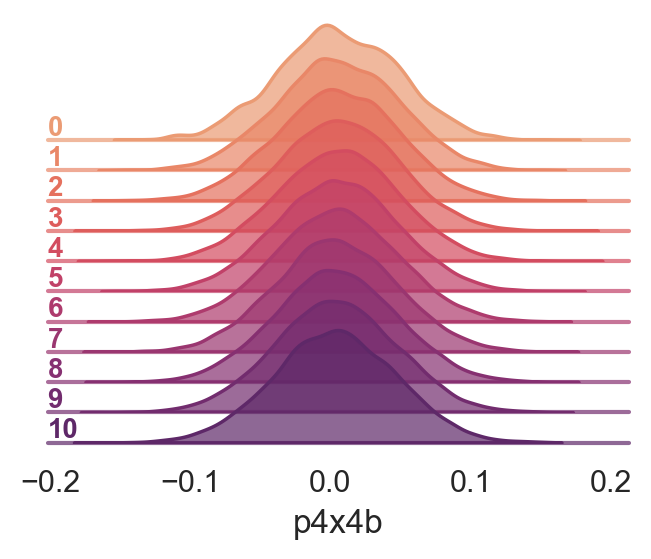

In [10]:
num_chains_to_plot = 16

run_dataset = inference_results.run_data.get_dataset(therm_frac=0.1)
for key, val in run_dataset.data_vars.items():
    if key not in to_plot:
        continue
        
    val = val[:num_chains_to_plot]
    fig, ax = plt.subplots(constrained_layout=True, figsize=set_size())
    _ = val.plot(ax=ax)
    
_ = make_ridgeplots(run_dataset, num_chains_to_plot)